# Background

__Description__:

Pillar is creating an innovative way to automatically select and splice clips from Twitch videos for streamers. This repo is focusing on the algorithm aspect. Three main algorithms are being tested.

1. Find the best moments in clips based on where the most users participated. Most is defined as the *ratio of unique users* during a 2 min section to unique users for the entire session.
1. Find the best moments in clips based on when rate of messages per user peaked. This involves answering the question "at which 2 min segment do the most users send the most messages?". If users X, Y, and Z all send 60% of their messages at timestamp range delta, then that timestamp might qualify as a "best moment"
2. Find the best moments in clips based on where the most users participated. Most is defined as the *number of unique users* during a 2 min section.

__Datasets used__:
1. Preliminary data `prelim_df`: 545 rows representing one 3 hour 35 minute 26 second twitch stream chat of [Hearthstone by LiiHS](https://www.twitch.tv/videos/963184458)
    * Used to create initial json import and resulting df clean/merge function `organize_twitch_chat`
2. Big data `big_df`: 2409 rows representing one 7 hour 37 minute, 0 second twitch stream chat of [Hearthstone by LiiHS](https://www.twitch.tv/videos/955629991)
    * Used to create all algorithms

## Current status

__Finished:__
1. Algorithm 1, 2, 3
2. Graphing of results

__To do:__
1. Clean up helper functions to be more general
1. Write sanity checks
1. Double and triple check the algorithms. Currently they don't look accurate, maybe

## Outline

1. Preliminary Data
1. Big Data
    1. User stats
1. __Algorithm 1__: percent user participation
    1. Results: top 5 moments
    1. Graphs
1. __Alogirthm 2__: number of users
    1. Per hour
    2. Per 2 minutes
1. __Algorithm 3__: percent user activity
    1. Per unique user
    2. Per hour

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import datetime as dt
import json

# Preliminary Data

Used to create data cleaning function

In [3]:
def organize_twitch_chat(json_name):
    data = pd.read_json(json_name, orient='records')
    df = data[['created_at','updated_at','commenter','message']]
    messages = df['message'].apply(pd.Series).drop(['fragments','user_color','user_notice_params'],axis=1)
    users = df['commenter'].apply(pd.Series)
    
    df = df.drop(['message','commenter'], axis=1) # duplicate info
    df = pd.concat([df,users,messages],axis=1)
    df = df.iloc[:,[0,1,2,3,4,5,6,9,10,11,12,13]] # select cols that arent duplicates
    
    return df

In [102]:
prelim_df = organize_twitch_chat("sample_data.json")
prelim_df = prelim_df.sort_values('created_at')

In [104]:
# Find length of entire session
prelim_df.iloc[-1,0] - prelim_df.iloc[0,0]

Timedelta('0 days 03:35:26.011000')

In [105]:
prelim_df.shape

(545, 12)

In [5]:
prelim_df['time_clipped'] = prelim_df['created_at'].astype(str).str.extract('(\d\d\d\d-\d\d-\d\d \d\d:\d\d)')

In [6]:
prelim_df.groupby('display_name').count().sort_values('body')

,created_at,updated_at,_id,name,type,bio,logo,body,is_action,user_badges,emoticons,time_clipped
display_name,,,,,,,,,,,,
mdsvellhoo,1,1,1,1,1,0,1,1,1,0,0,1
chicken2013,1,1,1,1,1,0,1,1,1,0,0,1
luuser830,1,1,1,1,1,0,1,1,1,1,0,1
Pekoeta,1,1,1,1,1,0,1,1,1,1,1,1
littleballofhate,1,1,1,1,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
stevekay4444,20,20,20,20,20,0,20,20,20,20,1,20
CptnJLPicard,22,22,22,22,22,0,22,22,22,0,0,22
ninaisnoob,37,37,37,37,37,37,37,37,37,37,10,37


Text(0.5, 1.0, 'Messages per User')

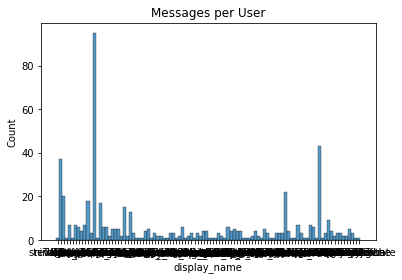

In [7]:
sns.histplot(prelim_df['display_name'])
plt.title('Messages per User')

# Big Data

[Twitch Source](https://www.twitch.tv/videos/955629991)

In [8]:
big_df = organize_twitch_chat("big_data.json") # fetch appropriate data

Text(0.5, 1.0, 'Message Count')

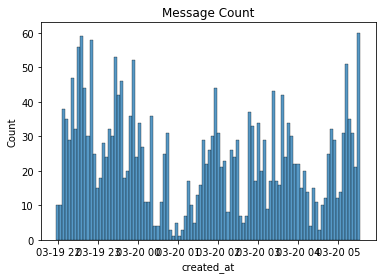

In [9]:
sns.histplot(big_df['created_at'], bins=100)
plt.title("Message Count")

Text(0.5, 1.0, 'Messages per User')

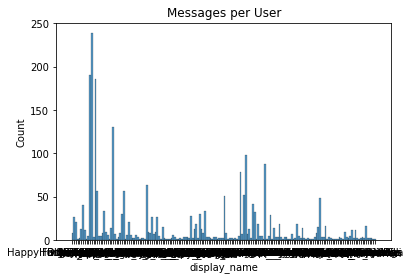

In [10]:
sns.histplot(big_df['display_name'])
plt.title("Messages per User")

## User Stats

In [11]:
def user_stats(dataframe):
    '''
    Returns the user who sent the most messages, most emoticons, and who changed their username the most
    '''
    temp_df = dataframe.groupby("name").count().reset_index()
    temp_df['username_chg'] = temp_df['_id'] - temp_df['display_name'] # if mismatch in count, then its probs changed username
    
    stats = {}
    for col in ['_id','emoticons', 'username_chg']:
        sort = temp_df.sort_values(col, ascending=False)[['name',col]].iloc[0]
        stat = sort[col]
        _id = sort['name']
        
        if col == '_id':
            col = 'num_messages'
        stats[col] = [_id, stat]
    
    return stats

In [12]:
user_stats(big_df)

{'num_messages': ['dominickstarcraft', 239],
 'emoticons': ['gassyvegan247', 27],
 'username_chg': ['21up21', 0]}

# Helper Functions and Classes

## Split into hour sections

In [13]:
class dfSplitter():
    def __init__(self, dataframe):
        '''
        Splits dataframe into multiple dataframes, each 1 hour long

        output:
        ------
        my_list: list
            List of dataframes
        '''
        # init function finds the first split
        dataframe = dataframe.sort_values("created_at")
        first = dataframe[dataframe['created_at'] <= dataframe.loc[0,'created_at'] + pd.Timedelta(hours = 1)]
        self.last_i = first.index.max()
        self.dataframe = dataframe
        self.result = [] # list to append starting timestamp + datasets to
        self.result.append(dataframe.iloc[0, 0]) # NOTE: assumes first col is always "created_at" col
        self.result.append(first)
        
    def find_rest(self):
        '''
        Uses last index of first split to find the others
        '''
        dataframe = self.dataframe
        last_i = self.last_i
        if last_i+1 != len(dataframe):
            new_df = dataframe.loc[last_i+1:,:] # clip df to start at last_i
            newest = new_df[new_df['created_at'] <= new_df.loc[last_i+1,'created_at'] + pd.Timedelta(hours=1)] # filter by hour
            self.result.append(newest) # store in list
            self.last_i = newest.index.max()
            
            self.find_rest() # repeat
        else:
            return dataframe # never actually used

In [14]:
def sanity_time_check(dataframe):
    '''
    Checks the time length of dataframe
    '''
    return dataframe['created_at'].max() - dataframe['created_at'].min()

def sanity_list_checker(list1):
    '''
    Prints out detailed information for each item in the list
    '''
    for data in list1:
        print(f"Hour {data['hour_section'].unique()} length: {sanity_time_check(data)}")

## Split each section into 2 minute chunks

In [40]:
class fminChats():
    def __init__(self,dataframe, big_unique, min_= 2):
        '''
        Finds the percent unique chatters that chatted every min_ minutes
        
        input
        -----
        dataframe: pd.DataFrame
            Twitch chat dataframe organized and split by dfSplitter
        big_unique: int
            Total number of unique chatters for the entire Twitch stream
        min_: int
            Minute range to find timestamps for. Ex: Find 2 min long timestamps.
        '''
        
        # init function finds the first split
        dataframe = dataframe.sort_values("created_at")
        first = dataframe[dataframe['created_at'] <= dataframe.iloc[0,0] + pd.Timedelta(minutes = min_)]
        
        self.min_ = min_
        self.total_uniques = len(dataframe['_id'].unique())
        self.big_unique = big_unique
        
        self.last_i = first.index.max()
        self.dataframe = dataframe
        
        self.result = []
        self.result.append(first)
        
    def find_rest(self):
        '''
        Uses last index of first split to find the others
        '''
        dataframe = self.dataframe
        last_i = self.last_i
        if last_i+1 < dataframe.index.max(): # NOT len(dataframe), that bugs out and i dont wanna explain why
            new_df = dataframe.loc[last_i+1:,:] # clip df to start new min_ min calc at last_i+1
            newest = new_df[new_df['created_at'] <= new_df.loc[last_i+1,'created_at'] + pd.Timedelta(value=self.min_, unit='minutes')] # filter by minute
            self.result.append(newest) # store in list
            
            self.last_i = newest.index.max()
            self.find_rest() # repeat
        else:
            x=''
    
    def perc_uniques(self, chunk_list):
        '''
        Finds the percent unique chatters for eachd dataframe in the list. Dataframes assumed to be split using self.find_rest.
        '''
        
        perc_unique = {
                f'{self.min_}min_chunk':[],
                'start':[],
                'end':[],
                'num_unique':[],
                'perc_rel_unique':[],
                'perc_abs_unique':[]
        }
        
        
        for i in range(len(chunk_list)):
            # calcuate
            chunk = i
            unique = len(chunk_list[i]['_id'].unique())
            timestamp = [chunk_list[i]['created_at'].min(), chunk_list[i]['created_at'].max()]
            perc_rel = unique/self.total_uniques # this is the total uniques in THAT DATAFRAME, ie the hourly cut
            perc_abs = unique/self.big_unique # this is the total uniques in the entire twitch session
            # store
            perc_unique[f'{self.min_}min_chunk'].append(chunk)
            perc_unique['start'].append(timestamp[0])
            perc_unique['end'].append(timestamp[1])
            perc_unique['num_unique'].append(unique)
            perc_unique['perc_rel_unique'].append(perc_rel)
            perc_unique['perc_abs_unique'].append(perc_abs)
            
        df_unique = pd.DataFrame(perc_unique)
        df_unique['elapsed'] = df_unique['end'] - df_unique['start']
        return df_unique
    

The above class will do everything for one df. The following functions will tie both classes together and format the results.

In [16]:
def results_jsonified(results, vid_id, first_sec):
    '''
    Extracts relevant results and makes them machine readable
    
    input
    -----
    results: pd.DataFrame
        DataFrame with at least start, end columns.
    vid_id: int
        Twitch id of video
    '''
    results['first_sec'] = first_sec # to calculate elapsed time from first sec, in seconds
    results = results.sort_values('perc_rel_unique', ascending=False) # so json format is returned with top result being the most relevant
    json_results = []
    for i, row in results.iterrows():
        og = row['first_sec']
        start = row['start']
        end = row['end']
        
        start_sec = dt.timedelta.total_seconds(start-og) # find difference between first sec and given timestamp, convert that to seconds
        end_sec = dt.timedelta.total_seconds(end-og)
        
        dict_ = {"startTime":start_sec,
                 "endTime":end_sec,
                 "videoId":vid_id}
        json_results.append(dict_)
        
    return json_results
        
def hour_iterator(big_df, vid_id, min_=2):
    '''
    Pushes all dfs in a list through the fminChats function, returns a dataframe of results
    
    input
    -----
    big_df: pd.DataFrame
        Df of the entire twitch session. This is the one that was split by dfSplitter class
    min_: int
        How long a timestamp range should be
    vid_id: int
        Twitch id of video. Needed for jsonify function
    '''
    ds = dfSplitter(big_df) # initiate
    ds.find_rest() # split big_df into 1 hour long separate dfs
    hour_list = ds.result # result stored in class var. NOTE: index 0 is always the very first timestamp of big_df
    first_sec = hour_list[0]
    hour_list = hour_list[1:]

    # initiate empty results df
    results = pd.DataFrame(columns=['hour', f'{min_}min_chunk', 'start', 'end', 'num_unique', 'perc_rel_unique', 'perc_abs_unique'])
    max_uniques = len(big_df['_id'].unique()) # the total number of unique chatters for the entire twitch session

    # iterate all sections through the class
    for i in range(len(hour_list)):
        fm = fminChats(hour_list[i], max_uniques)
        _n = fm.find_rest() # _n not needed
        chunk_list = fm.result # get back list of dfs, each 2 minutes long

        hr_uniques = fm.perc_uniques(chunk_list)
        hr_uniques['hour'] = i + 1
        results = results.append(hr_uniques)

    results['elapsed'] = results['end'] - results['start'] # to double check length
    pretty_results = results.reset_index(drop=True) # prettify
    
    json_results = results_jsonified(results, vid_id, first_sec) # ordered by top perc_rel_unique
    
    return pretty_results, json_results

In [110]:
def save_json(json_results, name):
    '''
    Saves json_results in txt file.
    '''
    str_  = '['
    for dict_ in json_results:
        str_ += str(dict_) + ', \n '
    str_ += ']'
    
    with open(f"{name}.txt",'w') as f:
        f.write(str_)

# Algorithm 1: percent user participation

__Description__: Try to find the best moments in clips based on where the most users participated
1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE `dfSplitter`
1. ~~Find total number of unique users that participated in session~~ DONE
1. ~~Find % of users that participated at any given `2 minute` timestamp~~
1. ~~Isolate `top 3` timestamps per session~~

In [17]:
results, json_results = hour_iterator(big_df, vid_id=955629991)

In [112]:
# save_json(json_results, "algo1_results")

## Results Top five moments

In [19]:
# for normal people
results.sort_values('perc_abs_unique',ascending=False).head()

,hour,2min_chunk,start,end,num_unique,perc_rel_unique,perc_abs_unique,elapsed
196,8,16,2021-03-20 05:32:08.108000+00:00,2021-03-20 05:33:48.767000+00:00,18,0.545455,0.104651,0 days 00:01:40.659000
129,6,0,2021-03-20 02:57:53.904000+00:00,2021-03-20 02:59:51.806000+00:00,15,0.319149,0.087209,0 days 00:01:57.902000
147,6,18,2021-03-20 03:38:02.837000+00:00,2021-03-20 03:40:01.726000+00:00,15,0.319149,0.087209,0 days 00:01:58.889000
123,5,19,2021-03-20 02:44:47.050000+00:00,2021-03-20 02:46:44.245000+00:00,14,0.274510,0.081395,0 days 00:01:57.195000
114,5,10,2021-03-20 02:19:59.386000+00:00,2021-03-20 02:21:58.812000+00:00,14,0.274510,0.081395,0 days 00:01:59.426000


[Twitch Source](https://www.twitch.tv/videos/955629991)

Variables:
* `hour`: section of twitch chat df, after df was split into 1 hour sections
* `xmin_chunk`: chunk of hour section, after section was split into x min chunks
* `start`: starting timestamp of chunk
* `end`: ending timestamp of chunk
* `num_unique`: number of unique chatters in that chunk
* `perc_rel_unique`: percent of unique __hour section__ chatters participating in that chunk
* `perc_abs_unique`: percent of unique __twitch df__ chatters participating in that chunk

__Conclusion__: The max relative chat engagement was around 55% in the eighth hour of twitch chat during chunk_16. Timestamps `03-20 05:32` to `03-20 05:33` are good candidates

In [20]:
# for engineers
json_results[:8]

[{'startTime': 27319.612, 'endTime': 27420.271, 'videoId': 955629991},
 {'startTime': 26689.814, 'endTime': 26808.451, 'videoId': 955629991},
 {'startTime': 18065.408, 'endTime': 18183.31, 'videoId': 955629991},
 {'startTime': 20474.341, 'endTime': 20593.23, 'videoId': 955629991},
 {'startTime': 3152.329, 'endTime': 3271.822, 'videoId': 955629991},
 {'startTime': 26320.325, 'endTime': 26439.613, 'videoId': 955629991},
 {'startTime': 8672.863, 'endTime': 8759.628, 'videoId': 955629991},
 {'startTime': 6851.107, 'endTime': 6965.998, 'videoId': 955629991}]

In [21]:
save_json(json_results) # save as txt file

## Graphs

/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent chatters, relative to each hour')

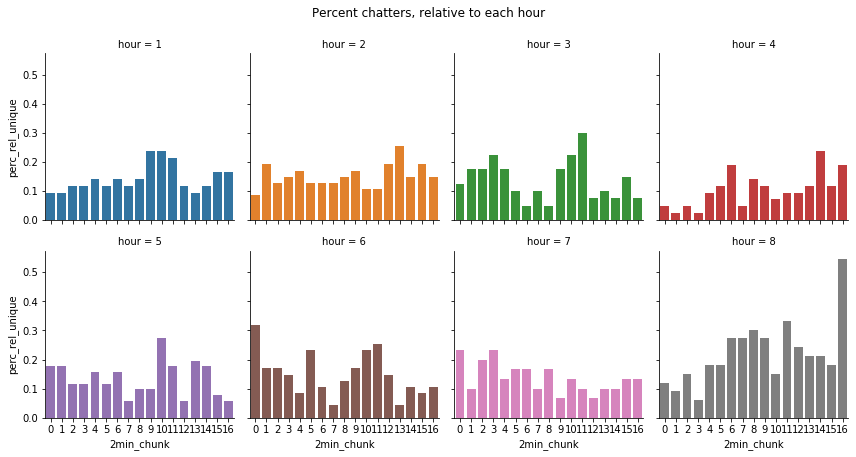

In [98]:
g = sns.FacetGrid(results,col='hour', col_wrap = 4, hue = 'hour')
g.map(sns.barplot,'2min_chunk','perc_rel_unique')

plt.suptitle("Percent chatters, relative to each hour",y=1.05)

/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent of twitch session chatters participating at each chunk')

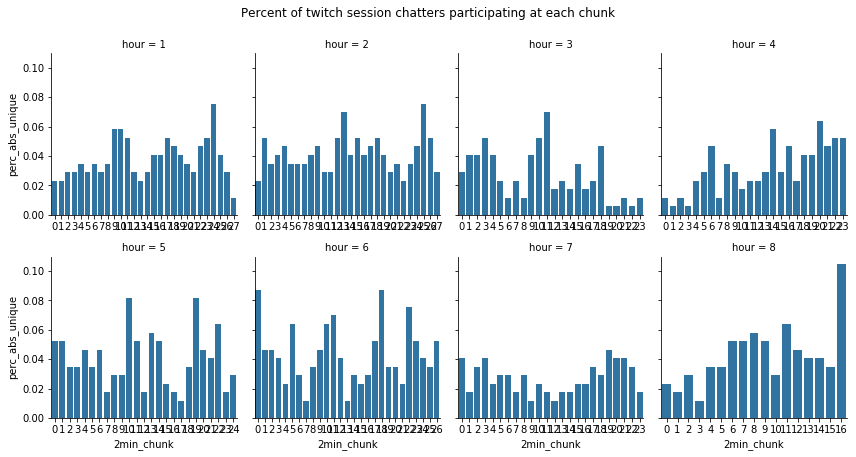

In [23]:
g = sns.FacetGrid(results,col='hour',sharex=False, col_wrap = 4)
g.map(sns.barplot,'2min_chunk','perc_abs_unique')

plt.suptitle("Percent of twitch session chatters participating at each chunk",y=1.05)

### BUG

Why do the perc_abs_unique and perc_rel_unique have the same exact graphs???

# Algorithm 2: number of users

__Description__: Try to find the best moments in clips based on where the most users participated
1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE `dfSplitter`
1. ~~Find total number of unique users that participated in session~~ DONE
1. ~~Find total number of unique users per 2 min chunk~~
1. Isolate `top 3` timestamps per session

In [66]:
# split df into hours
dfs = dfSplitter(big_df)
dfs.find_rest()
hourly_list = dfs.result
del hourly_list[0] # delete first timestamp

In [78]:
# split hours into 2 min
chunk_list = []
for i in range(len(hourly_list)):
    fmc = fminChats(hourly_list[i], len(big_df['_id'].unique()))
    fmc.find_rest()
    result = fmc.result
    for chunk in range(len(result)):
        result[chunk]['hour'] = i
        result[chunk]['chunk'] = chunk
        chunk_list.append(result[chunk])

/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Per hour

In [79]:
hourly_chatters = pd.DataFrame(columns=['hour','num_chatters'])
for hour in range(len(hour_list)):   
    chatters = len(hour_list[hour]['_id'].unique())
    my_dict = {
        "hour": [hour],
        "num_chatters":[chatters]
    }
    
    hourly_chatters = hourly_chatters.append(pd.DataFrame(my_dict))

Text(0.5, 1, 'Number of unique chatters per hour')

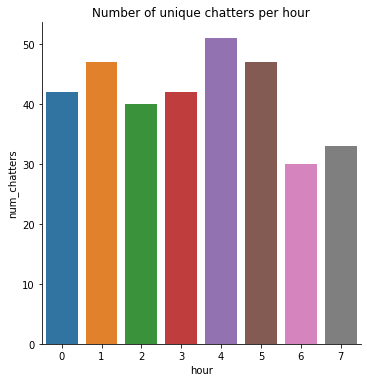

In [80]:
sns.catplot(x="hour",y="num_chatters",data=hourly_chatters,kind='bar')
plt.title("Number of unique chatters per hour")

## Per 2 min

In [88]:
chunky_chatters = pd.DataFrame(columns=['hour','chunk','num_chatters'])
for chunk in range(len(chunk_list)):
    chunk_df = chunk_list[chunk]
    chatters = len(chunk_df['_id'].unique())
    my_dict = {
        "hour": [chunk_df.iloc[0,-2]],
        "chunk": [chunk_df.iloc[0,-1]],
        "num_chatters": [chatters]
    }
    
    chunky_chatters = chunky_chatters.append(pd.DataFrame(my_dict))

In [ ]:
sns.barplot()

/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Number of unique chatters each hour')

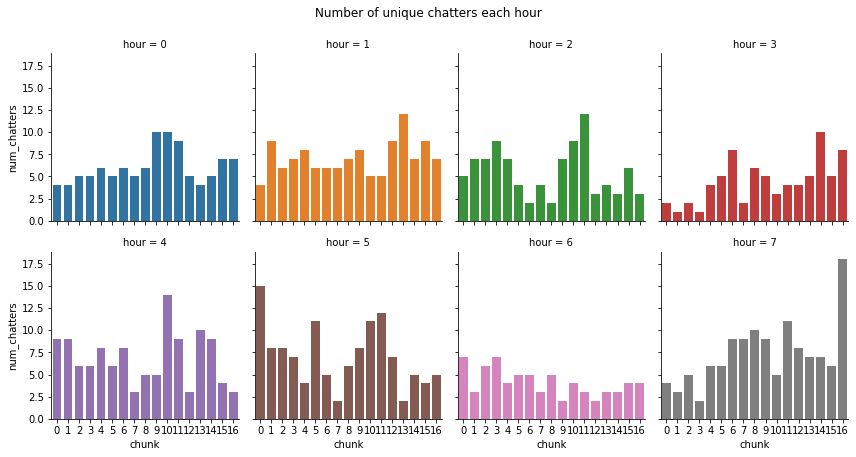

In [99]:
g = sns.FacetGrid(chunky_chatters,col='hour', col_wrap = 4, hue = 'hour')
g.map(sns.barplot,'chunk','num_chatters')

plt.suptitle("Number of unique chatters each hour",y=1.05)

# Algorithm 3: percent user activity

__Description__: Try to find the best moments in clips based on when rate of messages per user peaked

1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE
1. ~~Find overall message rate per 2 minutes per users~~ DONE
1. ~~Identify timestamps where `message_rate` peaked~~ DONE

Based on the above, it looks like top message sender sent the top message at all hours

In [24]:
dfs = dfSplitter(big_df)
dfs.find_rest()
hour_list = dfs.result
first_hour = hour_list[0]
del hour_list[0]

In [25]:
chat_rates = ''

for i in range(len(hour_list)):
    hour_list[i]['hour'] = i # label each dataset so we can tell what hour they came from

/home/jupyter-pomkos/.conda/envs/mess_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [26]:
chunk_list = []
for hour in hour_list:
    fmc = fminChats(hour, big_df['_id'].unique()) # split into 2 min segments
    fmc.find_rest()
    
    for chunk in fmc.result:
        chunk_list.append(chunk) # fmc.result gets returned as a list

In [27]:
import datetime as dt

In [28]:
def rate_finder(dataframe, hour, x=2):
    '''
    Finds the rate of messages sent per X minutes for each user in the dataframe.
    
    NOTE: if only 1 timestamp in chunk dataframe, assumes the chunk is exactly 2 minutes before the next chunk in the entire twitch chat stream
    '''
    # Initiate new df
    chat_rate_df = pd.DataFrame(columns = ['hour','chunk','time_start','time_end','_id','num_chats', 'chat_rate'])
    chatters = dataframe['_id'].unique() # id unique chatters for this chunk
    
    
    for i in range(len(chatters)):
        temp_df = dataframe[dataframe['_id']==chatters[i]] # isolate chatter's data
        hour = hour
        chunk = i
        time_start = dataframe.iloc[0,0]
        time_end = dataframe.iloc[-1,0]
        _id = chatters[i]
        num_chats = len(temp_df['body']) # count how many chats were sent by them
        time_d = dt.timedelta.total_seconds(dataframe.iloc[-1,0] - dataframe.iloc[0,0]) 

        if time_d > 0:
            chat_rate = (num_chats/time_d) * 60 * x # use time_d to calculate chat/sec, then multiply to get user requested rate
        elif time_d == 0:
            # if there is only 1 message in the chunk, there will be only 1 timestamp
            # in that case assume that time_d = 2
            time_d = 2
            chat_rate = (num_chats/time_d) * 60 * x
        else:
            chat_rate = -100 # if number is negative, math is wrong somewhere

        # gather results
        results = pd.DataFrame({
            'hour':[hour],
            'chunk':[chunk],
            'time_start':[time_start],
            'time_end':[time_end],
            '_id':[_id],
            'num_chats':[num_chats],
            'chat_rate':[chat_rate]
        })

        chat_rate_df = chat_rate_df.append(results) # store in df
    return chat_rate_df.reset_index(drop=True)
        

## Per unique user

In [29]:
chat_rates = pd.DataFrame(columns = ['hour', 'chunk', 'time_start', 'time_end', '_id', 'num_chats', 'chat_rate'])

for chunk in chunk_list:
    hour = chunk.iloc[-1,12] # col 12 is hour. 
    chat_rates = chat_rates.append(rate_finder(dataframe = chunk, hour = hour, x=2)) 
    
chat_rates = chat_rates.reset_index(drop=True)

In [30]:
# eliminate rows where the user only chatted once (so the timedelta is 0)
deltas = []
for i, row in chat_rates.iterrows():
    delta = dt.timedelta.total_seconds(row['time_end'] - row['time_start'])
    deltas.append(delta)

chat_rates['elapsed'] = deltas
chat_rates = chat_rates[chat_rates['elapsed'] != 0]

Text(0.5, -0.15, 'One dot represents one user')

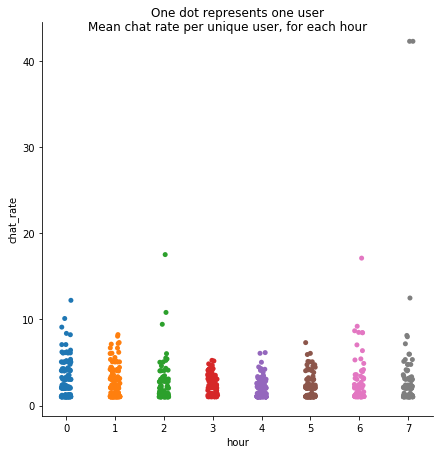

In [31]:
sns.catplot(x='hour',y='chat_rate', data=chat_rates, kind = 'strip',height=6)
plt.suptitle("Mean chat rate per unique user, for each hour",y=0.98)
plt.title("One dot represents one user",y=-0.15)

__Interpretation__: There were three chunks (at hours 2,6,7 respectively) where mean unique user chat rate was higher than anywhere else

In [32]:
isolated = chat_rates[chat_rates['hour']==7]
isolated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 1115 to 1239
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   hour        125 non-null    object             
 1   chunk       125 non-null    object             
 2   time_start  125 non-null    datetime64[ns, UTC]
 3   time_end    125 non-null    datetime64[ns, UTC]
 4   _id         125 non-null    object             
 5   num_chats   125 non-null    object             
 6   chat_rate   125 non-null    float64            
 7   elapsed     125 non-null    float64            
dtypes: datetime64[ns, UTC](2), float64(2), object(4)
memory usage: 8.8+ KB


In [33]:
mean_rates = chat_rates.groupby(['hour','chunk']).mean().reset_index()

In [34]:
mean_rates.sort_values('chat_rate', ascending=False).head(10)

,hour,chunk,chat_rate,elapsed
87,7,1,5.616447,105.146882
86,7,0,4.851385,105.146882
101,7,15,4.768575,100.659000
78,6,0,3.991713,103.504125
100,7,14,3.576431,100.659000
1,0,1,3.497183,111.750143
96,7,10,3.486104,109.648000
0,0,0,3.420562,111.750143
26,2,0,3.296661,92.380455
3,0,3,3.230044,114.060630


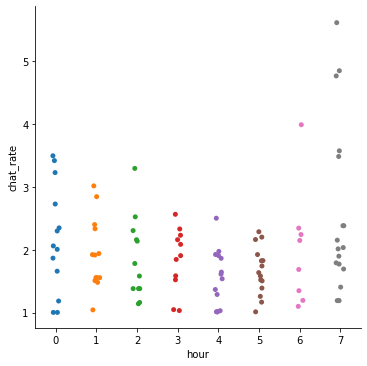

In [35]:
sns.catplot(x='hour',y='chat_rate',data=mean_rates, kind='strip')

## Per hour

In [36]:
def big_rate_finder(dataframe, x=2):
    '''
    Finds the overall chat rate per X minutes, regardless of chatter ID
    '''
    
    dataframe = dataframe.sort_values('created_at')
    seconds = dt.timedelta.total_seconds(dataframe.iloc[-1,0] - dataframe.iloc[0,0])
    messages = len(dataframe['body'])
    
    rate = (messages/seconds) * 60 * x
    
    return rate

In [37]:
hour_rates = {}
for i in range(len(hour_list)):
    rate = big_rate_finder(hour_list[i])
    hour_rates[i] = [rate]

In [38]:
hour_rates = pd.DataFrame(hour_rates).T.reset_index()
hour_rates.columns = ['hour','chat_per_2min']

Text(0.5, 1, 'Chat per 2min')

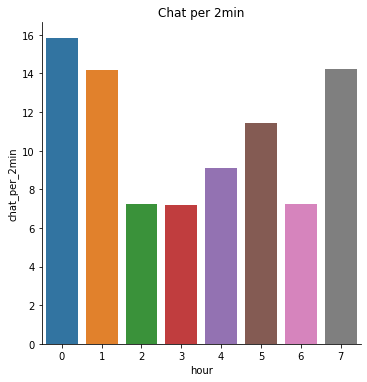

In [39]:
sns.catplot(x='hour',y='chat_per_2min',data=hour_rates, kind='bar')
plt.title("Chat per 2min")

__Interpretation__: Hours 0,1,7 had the most chat activity overall. 